## Versi 1

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import pairwise_distances

In [6]:
# Data
df_cleaned = pd.read_csv('tweets-data\cleaned.csv')

# Membuat BoW menggunakan CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df_cleaned['clean_text'])

In [12]:
# Banyak dokumen (baris) dan fitur (kata unik) yang ada setelah proses BoW
print(X.shape)

(470, 681)


In [13]:
# 10 kata pertama dalam vocabulary yang dihasilkan oleh CountVectorizer
print(vectorizer.get_feature_names_out()[:10])

['aamiin' 'abah' 'abis' 'adab' 'adik' 'admin' 'adu' 'agama' 'ah' 'ahli']


In [14]:
# Step 3: Apply LDA model using Scikit-learn's LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X)

# Step 4: Display the topics
# Get the words for each topic
words = vectorizer.get_feature_names_out()

for idx, topic in enumerate(lda_model.components_):
    print(f"Topic {idx}:")
    print([words[i] for i in topic.argsort()[-10:]])  # Top 10 words for each topic

Topic 0:
['main', 'ya', 'gibran', 'akun', 'udah', 'sih', 'prabowo', 'si', 'yg', 'fufufafa']
Topic 1:
['fufu', 'orang', 'akun', 'ga', 'si', 'ya', 'yg', 'lu', 'gibran', 'fufufafa']
Topic 2:
['jd', 'ya', 'aja', 'pagi', 'syahrini', 'akun', 'si', 'nya', 'susu', 'fufufafa']
Topic 3:
['main', 'gibran', 'novel', 'puput', 'malam', 'ready', 'susu', 'gembul', 'guru', 'fufufafa']
Topic 4:
['admin', 'gibran', 'mulyono', 'emang', 'prabowo', 'hina', 'anak', 'yg', 'akun', 'fufufafa']


In [20]:
# Step 5: Calculate Perplexity for LDA Model
# Perplexity measures how well the model predicts the data. Lower perplexity indicates better performance.
perplexity = lda_model.perplexity(X)
print(f"Model Perplexity: {perplexity}")

# Step 6: Calculate Coherence Score
# Coherence measures the interpretability of the topics by checking how frequently the top words of each topic appear together.

def coherence_score(lda_model, X, vectorizer, top_n=10):
    # Get topic-word distributions
    topic_word_matrix = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
    vocabulary = np.array(vectorizer.get_feature_names_out())

    # Compute pairwise distances between the top words of each topic
    coherence_scores = []
    for topic_idx, topic in enumerate(topic_word_matrix):
        top_words = vocabulary[np.argsort(topic)[-top_n:]]  # Get top_n words for each topic
        top_word_vectors = X[:, [vectorizer.vocabulary_[word] for word in top_words]].toarray()
        # Calculate pairwise cosine similarity
        topic_coherence = np.mean(pairwise_distances(top_word_vectors, metric="cosine"))
        coherence_scores.append(topic_coherence)

    return np.mean(coherence_scores)

coherence = coherence_score(lda_model, X, vectorizer)
print(f"Coherence Score: {coherence}")


Model Perplexity: 495.14426734043053
Coherence Score: 0.39589775465803934


## Versi 2

In [24]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import cohen_kappa_score
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# Step 1: Load cleaned data
df_cleaned = pd.read_csv('tweets-data/cleaned.csv')

# Step 2: Membuat BoW menggunakan CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df_cleaned['clean_text'])

# Tampilkan Bag of Words
print("=== Bag of Words ===")
print(pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).head())

=== Bag of Words ===
   aamiin  abah  abis  adab  adik  admin  adu  agama  ah  ahli  ...  wowo  ya  \
0       0     0     0     0     0      0    0      0   0     0  ...     0   0   
1       0     0     0     0     0      0    0      0   0     0  ...     0   0   
2       0     0     0     0     0      0    0      0   0     0  ...     1   0   
3       0     0     0     0     0      0    0      0   0     0  ...     0   0   
4       0     1     0     0     0      0    0      0   0     0  ...     0   0   

   yaa  yah  yahudi  yg  yoro  zionis  zionisme  zonauang  
0    0    0       0   0     0       0         0         0  
1    0    0       0   0     0       0         0         0  
2    0    0       0   1     0       0         0         0  
3    0    0       0   0     0       0         0         0  
4    0    0       0   0     0       0         0         0  

[5 rows x 681 columns]


In [26]:
# Step 3: Train LDA model with different components
perplexities = []
coherence_scores = []
n_topics_range = range(2, 11)  # Range of topics to evaluate

for n_topics in n_topics_range:
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_model.fit(X)
    
    # Calculate perplexity
    perplexity = lda_model.perplexity(X)
    perplexities.append(perplexity)

    # Calculate coherence score
    words = vectorizer.get_feature_names_out()
    
    def calculate_coherence_score(lda_model, X, words, n_top_words=10):
        topics = lda_model.components_
        top_words_per_topic = []

        for topic_idx, topic in enumerate(topics):
            top_word_indices = topic.argsort()[-n_top_words:]
            top_words_per_topic.append([words[i] for i in top_word_indices])

        # Simple Coherence Calculation (pairwise word co-occurrence within topics)
        coherence_scores = []
        for words_in_topic in top_words_per_topic:
            pairs = [(words_in_topic[i], words_in_topic[j]) for i in range(len(words_in_topic)) for j in range(i + 1, len(words_in_topic))]
            score = np.mean([cohen_kappa_score(X[:, vectorizer.vocabulary_[pair[0]]].toarray(), 
                                               X[:, vectorizer.vocabulary_[pair[1]]].toarray()) 
                             for pair in pairs if pair[0] in vectorizer.vocabulary_ and pair[1] in vectorizer.vocabulary_])
            coherence_scores.append(score)

        return np.mean(coherence_scores)

    coherence_score = calculate_coherence_score(lda_model, X, words)
    coherence_scores.append(coherence_score)

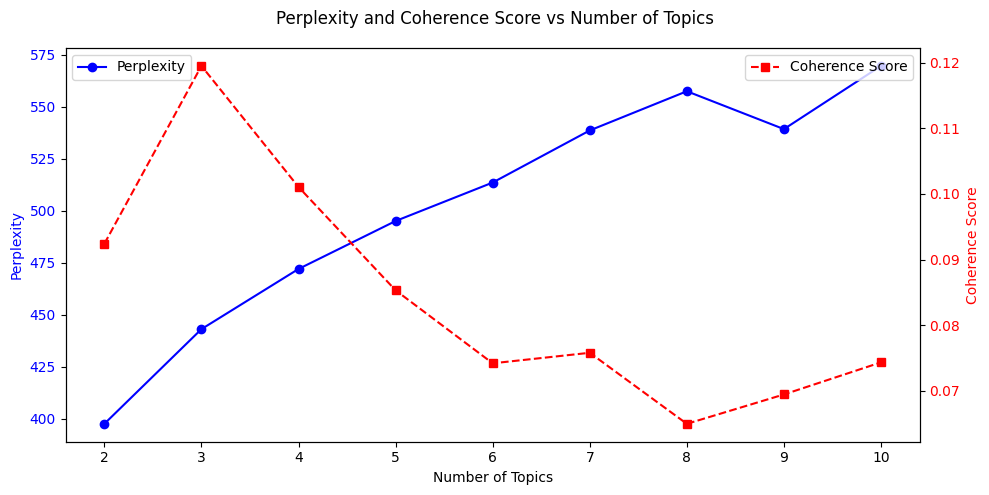


=== LDA Topics ===
Topic 1:
['main', 'ya', 'gibran', 'akun', 'udah', 'sih', 'prabowo', 'si', 'yg', 'fufufafa']
Topic 2:
['fufu', 'orang', 'akun', 'ga', 'si', 'ya', 'yg', 'lu', 'gibran', 'fufufafa']
Topic 3:
['jd', 'ya', 'aja', 'pagi', 'syahrini', 'akun', 'si', 'nya', 'susu', 'fufufafa']
Topic 4:
['main', 'gibran', 'novel', 'puput', 'malam', 'ready', 'susu', 'gembul', 'guru', 'fufufafa']
Topic 5:
['admin', 'gibran', 'mulyono', 'emang', 'prabowo', 'hina', 'anak', 'yg', 'akun', 'fufufafa']

=== Evaluation Results ===
   Number of Topics  Perplexity  Coherence Score
0                 2  397.627872         0.092407
1                 3  443.160514         0.119505
2                 4  472.087034         0.101055
3                 5  495.144267         0.085315
4                 6  513.636714         0.074199
5                 7  538.692336         0.075800
6                 8  557.536891         0.064978
7                 9  539.329587         0.069452
8                10  569.724743       

In [28]:
# Step 4: Visualize Perplexity and Coherence Score
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Perplexity and Coherence Score
ax1.plot(n_topics_range, perplexities, marker='o', color='b', label='Perplexity')
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Perplexity', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(n_topics_range, coherence_scores, marker='s', color='r', linestyle='--', label='Coherence Score')
ax2.set_ylabel('Coherence Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.suptitle('Perplexity and Coherence Score vs Number of Topics')
fig.tight_layout()

# Add a legend for each axis
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# Step 5: Display the topics from the final LDA model (with best n_components)
best_n_topics = 5  # Choose the best number based on the graphs
lda_model = LatentDirichletAllocation(n_components=best_n_topics, random_state=42)
lda_model.fit(X)

# Display the topics
words = vectorizer.get_feature_names_out()
print("\n=== LDA Topics ===")
for idx, topic in enumerate(lda_model.components_):
    print(f"Topic {idx + 1}:")
    print([words[i] for i in topic.argsort()[-10:]])  # Top 10 words for each topic

# Step 6: Create a DataFrame for the results
results_df = pd.DataFrame({
    'Number of Topics': n_topics_range,
    'Perplexity': perplexities,
    'Coherence Score': coherence_scores
})

# Display the table
print("\n=== Evaluation Results ===")
print(results_df)

Model Perplexity: Perplexity yang lebih rendah menunjukkan bahwa model lebih baik dalam memprediksi data.

Coherence Score: Semakin tinggi nilai koherensi (mendekati 1), semakin baik topik yang dihasilkan.